### Initial Decision Tree Regressor Exploration

In [1]:
%pylab inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.DataFrame.from_csv('cap-data/data-clean-round1/data_v2.csv', index_col= 0, encoding = 'utf-8')
nweight = pd.DataFrame.from_csv('cap-data/data-clean-round1/nweight.csv', index_col= 0, encoding = 'utf-8')
pc = pd.DataFrame.from_csv('cap-data/data-clean-round1/pc_v2.csv', index_col= 0, encoding = 'utf-8')
kwh = pd.DataFrame.from_csv('cap-data/data-clean-round1/kwh.csv', index_col= 0, encoding = 'utf-8')
pc_cat = pd.DataFrame.from_csv('cap-data/data-clean-round1/pc_cat_vars.csv', index_col= 0, encoding = 'utf-8')

### Splitting Up Dataset for kfold cross validation


In [3]:
from sklearn.model_selection import train_test_split

In [4]:
cat_data = data.filter(items = pc_cat['Variable Name'])
cat_data['NWEIGHT'] = nweight

In [5]:
X_train, X_test, y_train, y_test = train_test_split(cat_data, kwh, test_size=0.4)

In [6]:
nwgt_train = X_train.NWEIGHT
nwgt_train = nwgt_train.as_matrix()
X_train = X_train.drop('NWEIGHT', axis = 1)

nwgt_test = X_test.NWEIGHT
nwgt_test = nwgt_test.as_matrix()
X_test = X_test.drop('NWEIGHT', axis = 1)

### Feature Selection

In [7]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostRegressor

In [8]:
# Random forest with n =15 to determine feature importance
forest = ExtraTreesClassifier(n_estimators = 50)
#forest = AdaBoostRegressor(n_estimators = 50)
forest.fit(X_train, y_train.KWH, sample_weight = nwgt_train)
importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

In [9]:
# Data frame with feature rankings
rfeats = pd.DataFrame(columns = ['no', 'imp', 'name'])

for f in range(X_train.shape[1]):
    rfeats.loc[len(rfeats)] = [indices[f], importances[indices[f]], X_train.columns[indices[f]]]

In [10]:
rfeats.head(30)

,no,imp,name
0,59.0,0.006251,NUMMEAL
1,49.0,0.006183,OVENUSE
2,395.0,0.005992,MONEYPY
3,2.0,0.005977,REPORTABLE_DOMAIN
4,66.0,0.005969,AGERFRI1
5,372.0,0.005891,AGEHHMEMCAT2
6,371.0,0.005855,EDUCATION
7,8.0,0.005797,YEARMADERANGE
8,277.0,0.005796,WINDOWS
9,192.0,0.005609,EQUIPAGE


In [11]:
X_train.shape

(7249, 401)

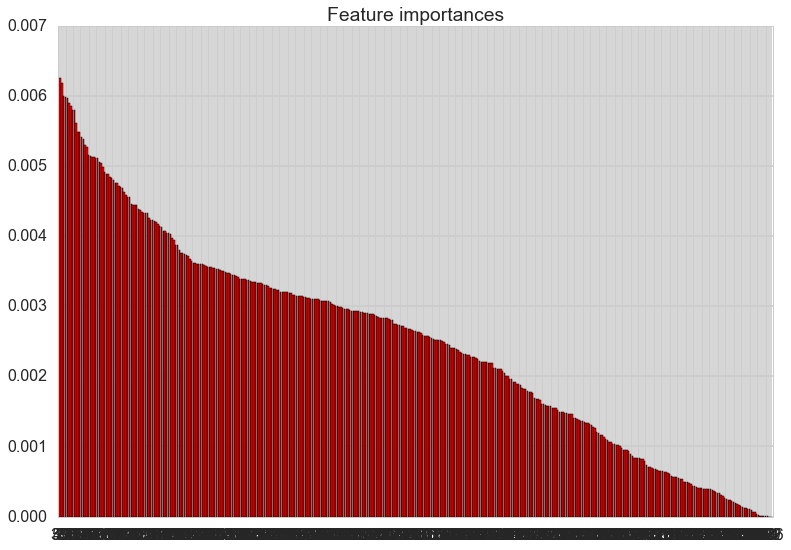

In [12]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [13]:
top_feat = rfeats[rfeats.imp >=0.005] # Arbitrary threshold for now

In [14]:
top_feat

,no,imp,name
0,59.0,0.006251,NUMMEAL
1,49.0,0.006183,OVENUSE
2,395.0,0.005992,MONEYPY
3,2.0,0.005977,REPORTABLE_DOMAIN
4,66.0,0.005969,AGERFRI1
5,372.0,0.005891,AGEHHMEMCAT2
6,371.0,0.005855,EDUCATION
7,8.0,0.005797,YEARMADERANGE
8,277.0,0.005796,WINDOWS
9,192.0,0.005609,EQUIPAGE


#### Filter out top features from data

In [15]:
X_train = X_train.filter(items = top_feat.name)
X_test = X_test.filter(items = top_feat.name)

In [16]:
X_train.shape

(7249, 24)

### Setting up decision tree Regressor

In [17]:
from sklearn import tree

In [18]:
#clf = tree.DecisionTreeRegressor()
# clf = clf.fit(X_train, y_train, sample_weight = nwgt_train)
# y_pred_train = clf.predict(X_train)

#forest = AdaBoostRegressor(n_estimators = 50)
#forest = ExtraTreesClassifier(n_estimators = 50)
forest.fit(X_train, y_train.KWH)#, sample_weight = nwgt_train)
y_pred_train = forest.predict(X_train)

In [19]:
# Examine RMSE for fitted data
from sklearn.metrics import mean_squared_error
print('RMSE: %s' % (mean_squared_error(y_train, y_pred_train, nwgt_train))**0.5)

RMSE: 0.0


In [20]:
# Examine RMSE for test data
y_pred_test = forest.predict(X_test)
print('RMSE: %s' % (mean_squared_error(y_test, y_pred_test, nwgt_test))**0.5)

RMSE: 8750.27775452


### The current RSME for the test data (8541) is worse than the RSME in my simple baseline regression of KWH vs SQFT (6877). Judging from the low RSME from the predictions on the training set, my model is overfit. How do I adjust?

In [21]:
y_pred_tr = pd.DataFrame()
y_pred_tr['yptrain'] = y_pred_train

y_pred_te = pd.DataFrame()
y_pred_te['yptest'] = y_pred_test

## Try Pipeline Model

In [25]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

In [23]:
X_train, X_test, y_train, y_test = train_test_split(cat_data, kwh, test_size=0.4)

In [24]:
nwgt_train = X_train.NWEIGHT
nwgt_train = nwgt_train.as_matrix()
X_train = X_train.drop('NWEIGHT', axis = 1)

nwgt_test = X_test.NWEIGHT
nwgt_test = nwgt_test.as_matrix()
X_test = X_test.drop('NWEIGHT', axis = 1)

In [29]:
estimator = SVR(kernel = 'linear')
selector = RFE(estimator, 30, step = 1)
selector = selector.fit(X_train, y_train.KWH)
selector.support_

array([False, False, False,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [35]:
# th = selector.support_

In [36]:
# pc_cat[th]

In [37]:
#top_feat